In [1]:

import numpy as np
import random
from numpy import loadtxt
from scipy.optimize import curve_fit
import os
import matplotlib.pyplot as plt

import scipy.special
from scipy.optimize import fmin


# Load data

In [4]:
data = np.loadtxt("./results/critical-atom-numbers/recipe-8-nc/functionals_E_N.dat")
# the header is: a_s  n_c_best_possible_fit  rho_min_x  rho_max_x  alpha  alpha_opt  beta  gamma  min_energy  
# read all data
a_s = data[:,0]
n_c_best_possible_fit = data[:,1]
rho_min_x = data[:,2]
rho_max_x = data[:,3]
alpha = data[:,4]
alpha_opt = data[:,5]
beta = data[:,6]
gamma = data[:,7]

# Take only the data where rho_min_x is smaller than 0.8, and rho_max_x is larger than 2.0
indices = np.where((rho_min_x < 0.7) & (rho_max_x > 1.7))
a_s = a_s[indices]
n_c_best_possible_fit = n_c_best_possible_fit[indices]
rho_min_x = rho_min_x[indices]
rho_max_x = rho_max_x[indices]
alpha = alpha[indices]
alpha_opt = alpha_opt[indices]
beta = beta[indices]
gamma = gamma[indices]





Text(0.5, 1.0, 'beta vs a_s')

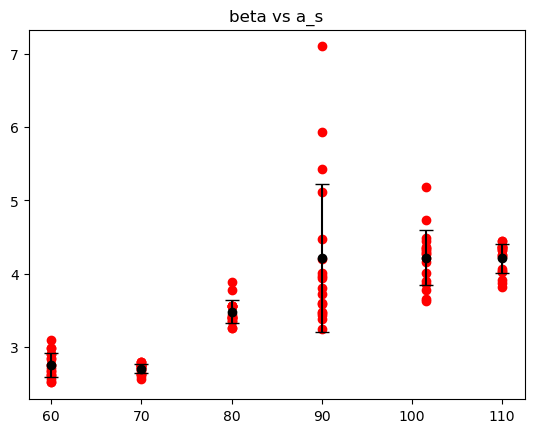

In [14]:
# Plot beta vs a_s
plt.plot(a_s, beta, 'o', label='beta', color='red')
# On the same plot, plot the error bar for each a_s
a_s_unique = np.unique(a_s)
average = np.zeros(len(a_s_unique))
std = np.zeros(len(a_s_unique))
for i in range(len(a_s_unique)):
    average[i] = np.average(beta[a_s==a_s_unique[i]])
    std[i] = np.std(beta[a_s==a_s_unique[i]])
# plot the error bar for each a_s, with larger error bars for a_s with less data points
plt.errorbar(a_s_unique, average, yerr=std, fmt='o', label='average beta', capsize=5, color='black')
plt.title("beta vs a_s")

Text(0.5, 1.0, 'gamma vs a_s')

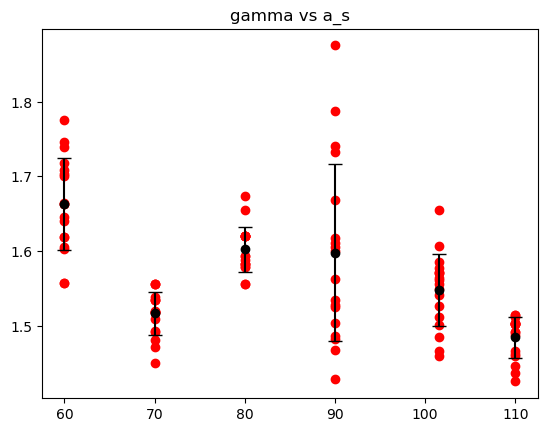

In [15]:
# Plot gamma vs a_s
plt.plot(a_s, gamma, 'o', label='gamma', color='red')
# On the same plot, plot the error bar for each a_s
a_s_unique = np.unique(a_s)
average = np.zeros(len(a_s_unique))
std = np.zeros(len(a_s_unique))
for i in range(len(a_s_unique)):
    average[i] = np.average(gamma[a_s==a_s_unique[i]])
    std[i] = np.std(gamma[a_s==a_s_unique[i]])
# plot the error bar for each a_s, with larger error bars for a_s with less data points
plt.errorbar(a_s_unique, average, yerr=std, fmt='o', label='average gamma', capsize=5, color='black')
plt.title("gamma vs a_s")